In [ ]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow streamlit -q


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("WiFiData.csv")
df.head()

Saving WiFiData.csv to WiFiData (1).csv


,Date,Time,Device,Location,SpeedDownload,SpeedUpload,StrengthStrongest,NumberofAvailableNetworks,NumberOfDevices,MacOrPC
0,10/1/2019,11:37,NaN,H105,46.46,70.71,NaN,NaN,NaN,NaN
1,10/1/2019,11:37,NaN,H105,39.79,23.97,NaN,NaN,NaN,NaN
2,10/1/2019,11:37,NaN,H105,136.85,112.70,-54.0,23.0,NaN,NaN
3,10/1/2019,11:37,NaN,H105,19.52,28.17,NaN,NaN,NaN,NaN
4,10/1/2019,11:37,NaN,H105,13.06,29.13,-61.0,NaN,NaN,NaN


In [ ]:
# Combine Date and Time into single datetime column (if separate)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Drop rows with invalid datetimes
df.dropna(subset=['Datetime'], inplace=True)

# Fill missing numeric values with median
for col in ['SpeedDownload','SpeedUpload','StrengthStrongest','NumberofAvailableNetworks','NumberOfDevices']:
    df[col] = df[col].fillna(df[col].median())

# Encode categorical columns
le = LabelEncoder()
for col in ['Device','Location','MacOrPC']:
    if col in df.columns:
        df[col] = le.fit_transform(df[col].astype(str))

# Sort by time
df = df.sort_values('Datetime')


In [ ]:
# Time-based features
df['Hour'] = df['Datetime'].dt.hour
df['Day'] = df['Datetime'].dt.day
df['Weekday'] = df['Datetime'].dt.weekday

# Target variable: Download speed
target = 'SpeedDownload'

# Features
features = ['SpeedUpload','StrengthStrongest','NumberofAvailableNetworks',
            'NumberOfDevices','Device','Location','MacOrPC','Hour','Day','Weekday']

X = df[features]
y = df[target]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 22.3041875
RMSE: 29.367069327841513
R² Score: -0.7401030037277263


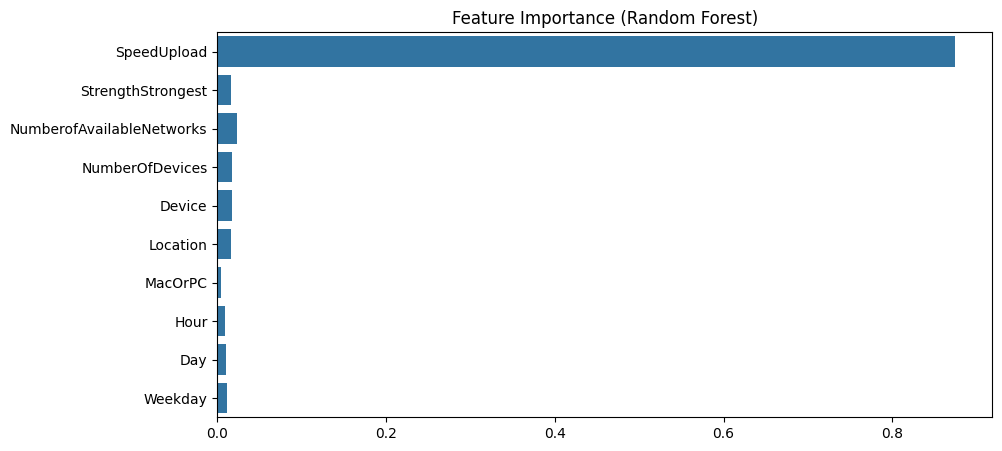

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=rf.feature_importances_, y=features)
plt.title("Feature Importance (Random Forest)")
plt.show()


In [ ]:
# For simplicity, use only SpeedDownload as time series
ts = df[['Datetime', 'SpeedDownload']].set_index('Datetime').resample('1H').mean().fillna(method='ffill')

# Prepare data for LSTM
window = 10
X_lstm, y_lstm = [], []
for i in range(window, len(ts)):
    X_lstm.append(ts.iloc[i-window:i, 0])
    y_lstm.append(ts.iloc[i, 0])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Split
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(window,1)),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=16, verbose=1)


/tmp/ipython-input-2628861696.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = df[['Datetime', 'SpeedDownload']].set_index('Datetime').resample('1H').mean().fillna(method='ffill')
/tmp/ipython-input-2628861696.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = df[['Datetime', 'SpeedDownload']].set_index('Datetime').resample('1H').mean().fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 788.0787
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 859.8291
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 599.3010
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 592.8627
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 550.7160
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 544.7565
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 671.6458
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 566.5075
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 464.2037
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 374.7283


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


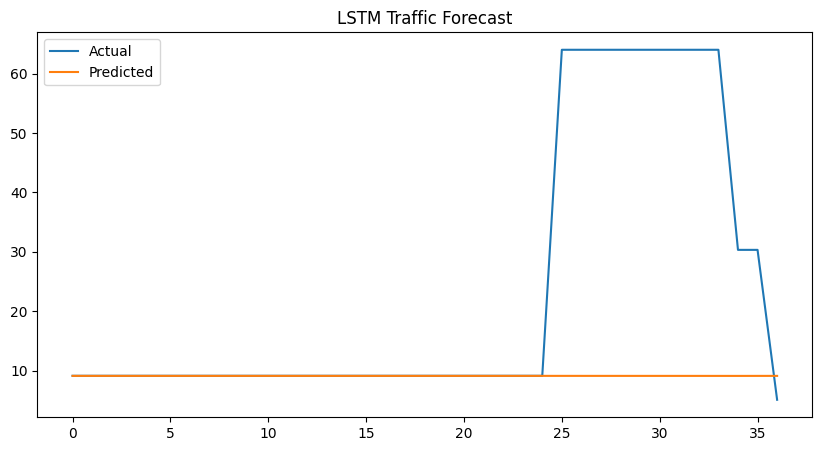

In [ ]:
y_pred_lstm = model.predict(X_test_lstm)

plt.figure(figsize=(10,5))
plt.plot(y_test_lstm, label='Actual')
plt.plot(y_pred_lstm, label='Predicted')
plt.title("LSTM Traffic Forecast")
plt.legend()
plt.show()


Detected anomalies: 3


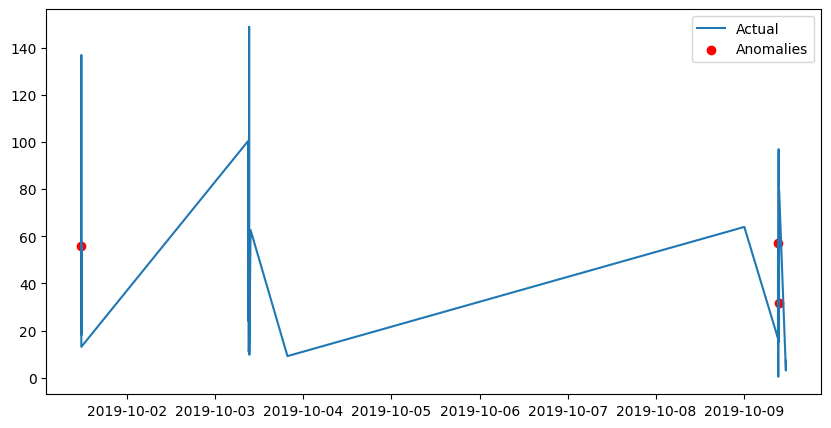

In [ ]:
df['Predicted_RF'] = rf.predict(X_scaled)
df['Error'] = abs(df['SpeedDownload'] - df['Predicted_RF'])
threshold = df['Error'].mean() + 2*df['Error'].std()

anomalies = df[df['Error'] > threshold]
print("Detected anomalies:", len(anomalies))

plt.figure(figsize=(10,5))
plt.plot(df['Datetime'], df['SpeedDownload'], label='Actual')
plt.scatter(anomalies['Datetime'], anomalies['SpeedDownload'], color='red', label='Anomalies')
plt.legend()
plt.show()


In [ ]:
!pip install psutil speedtest-cli pandas numpy scikit-learn tensorflow gradio plotly
import psutil, speedtest, pandas as pd, time, datetime

def collect_network_data():
    s = speedtest.Speedtest()
    s.get_best_server()
    download = s.download() / 1e6  # Mbps
    upload = s.upload() / 1e6
    io = psutil.net_io_counters()
    return {
        'Datetime': datetime.datetime.now(),
        'SpeedDownload': download,
        'SpeedUpload': upload,
        'BytesSent': io.bytes_sent,
        'BytesRecv': io.bytes_recv,
        'PacketsSent': io.packets_sent,
        'PacketsRecv': io.packets_recv
    }

# Example test:
for _ in range(3):
    print(collect_network_data())
    time.sleep(5)


{'Datetime': datetime.datetime(2025, 10, 31, 8, 43, 55, 825409), 'SpeedDownload': 2216.4200205699867, 'SpeedUpload': 790.0351529948555, 'BytesSent': 667922800, 'BytesRecv': 1705060287, 'PacketsSent': 173359, 'PacketsRecv': 256099}
{'Datetime': datetime.datetime(2025, 10, 31, 8, 44, 4, 272286), 'SpeedDownload': 2438.7555551512723, 'SpeedUpload': 800.4893951334416, 'BytesSent': 820670708, 'BytesRecv': 2116350442, 'PacketsSent': 189325, 'PacketsRecv': 283732}
{'Datetime': datetime.datetime(2025, 10, 31, 8, 44, 12, 16712), 'SpeedDownload': 4249.877266143006, 'SpeedUpload': 856.2744390555043, 'BytesSent': 973263477, 'BytesRecv': 2528015942, 'PacketsSent': 203334, 'PacketsRecv': 317349}


In [ ]:
import plotly.express as px
import gradio as gr
import numpy as np

# Maintain a rolling window of readings
live_df = pd.DataFrame(columns=['Datetime','SpeedDownload','SpeedUpload','BytesSent','BytesRecv'])

def live_monitor():
    global live_df
    while True:
        new_row = collect_network_data()
        live_df = pd.concat([live_df, pd.DataFrame([new_row])]).tail(50)  # keep last 50 readings

        # Preprocess (scale & predict)
        if len(live_df) > 10:
            # Convert necessary columns
            X_live = scaler.transform(live_df[features])
            preds = rf.predict(X_live)
            live_df['Predicted_RF'] = preds
            live_df['Error'] = abs(live_df['SpeedDownload'] - preds)

            # Detect anomalies
            threshold = live_df['Error'].mean() + 2 * live_df['Error'].std()
            anomalies = live_df[live_df['Error'] > threshold]

            # Create live plot
            fig = px.line(live_df, x='Datetime', y=['SpeedDownload', 'Predicted_RF'],
                          title="Live Wi-Fi Traffic (Actual vs Predicted)")
            fig.add_scatter(x=anomalies['Datetime'], y=anomalies['SpeedDownload'],
                            mode='markers', marker=dict(color='red', size=8),
                            name='Anomaly')
            yield fig
        time.sleep(10)


In [ ]:
!pip install psutil speedtest-cli gradio matplotlib pandas scikit-learn tensorflow
import psutil, time, pandas as pd
from datetime import datetime

def collect_live_network_data(duration=60, interval=5):
    """
    Collects live Wi-Fi I/O data for a given duration (seconds).
    Returns a DataFrame with timestamps and bytes sent/received.
    """
    records = []
    print("Collecting live Wi-Fi traffic data...")
    for _ in range(int(duration / interval)):
        net_io = psutil.net_io_counters(pernic=True)
        wifi = None
        for iface, stats in net_io.items():
            if "wi" in iface.lower() or "wl" in iface.lower():  # match wifi interfaces
                wifi = stats
                break
        if wifi:
            records.append({
                "timestamp": datetime.now(),
                "bytes_sent": wifi.bytes_sent,
                "bytes_recv": wifi.bytes_recv
            })
        else:
            print("⚠️ Wi-Fi interface not detected — using total network stats")
            total = psutil.net_io_counters()
            records.append({
                "timestamp": datetime.now(),
                "bytes_sent": total.bytes_sent,
                "bytes_recv": total.bytes_recv
            })
        time.sleep(interval)

    df = pd.DataFrame(records)
    # Calculate bytes sent/received difference per interval
    df["sent_rate"] = df["bytes_sent"].diff().fillna(0) / interval
    df["recv_rate"] = df["bytes_recv"].diff().fillna(0) / interval
    return df


In [ ]:
live_df = collect_live_network_data(duration=30, interval=5)
live_df.head()


⚠️ Wi-Fi interface not detected — using total network stats
⚠️ Wi-Fi interface not detected — using total network stats
⚠️ Wi-Fi interface not detected — using total network stats
⚠️ Wi-Fi interface not detected — using total network stats
⚠️ Wi-Fi interface not detected — using total network stats
⚠️ Wi-Fi interface not detected — using total network stats


,timestamp,bytes_sent,bytes_recv,sent_rate,recv_rate
0,2025-10-31 08:44:39.631306,973405867,2528178508,0.0,0.0
1,2025-10-31 08:44:44.633222,973425796,2528226359,3985.8,9570.2
2,2025-10-31 08:44:49.633915,973428179,2528228039,476.6,336.0
3,2025-10-31 08:44:54.636346,973435010,2528234513,1366.2,1294.8
4,2025-10-31 08:44:59.641463,973437459,2528236259,489.8,349.2


In [ ]:
live_df["total_rate"] = live_df["sent_rate"] + live_df["recv_rate"]

# Normalize / scale the input if you used a scaler earlier
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(live_df[["total_rate"]])

# Convert to LSTM input shape (samples, timesteps, features)
import numpy as np
X_live = np.reshape(scaled, (1, scaled.shape[0], 1))


In [ ]:
predicted_load = model.predict(X_live)
predicted_value = predicted_load.flatten()[0]
print("Predicted next traffic load:", predicted_value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Predicted next traffic load: 2.7076018


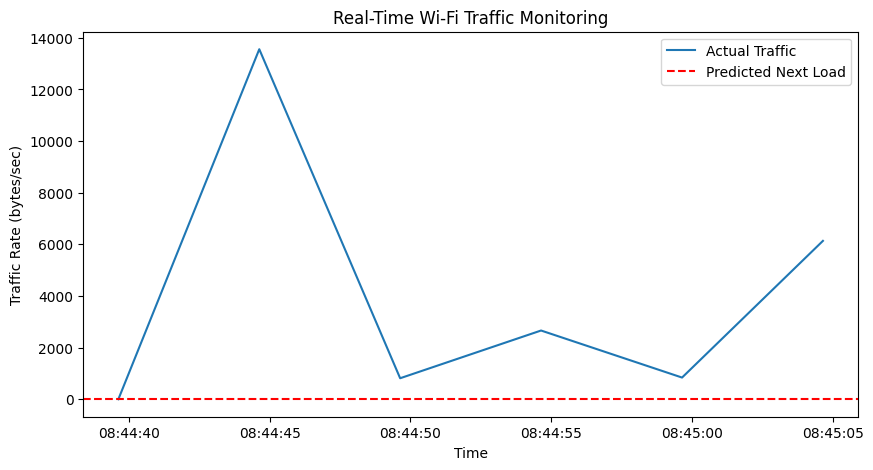

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(live_df["timestamp"], live_df["total_rate"], label="Actual Traffic")
plt.axhline(y=predicted_value, color="r", linestyle="--", label="Predicted Next Load")
plt.legend()
plt.title("Real-Time Wi-Fi Traffic Monitoring")
plt.xlabel("Time")
plt.ylabel("Traffic Rate (bytes/sec)")
plt.show()


In [ ]:
live_df["rolling_mean"] = live_df["total_rate"].rolling(window=3).mean()
live_df["rolling_std"] = live_df["total_rate"].rolling(window=3).std()

# Simple rule: flag if traffic > mean + 2*std
# Instead of 2*std, use 1.0 or 1.5
live_df["anomaly"] = live_df["total_rate"] > (live_df["rolling_mean"] + 1.0 * live_df["rolling_std"])

anomalies = live_df[live_df["anomaly"]]
print(anomalies[["timestamp", "total_rate"]])


                   timestamp  total_rate
5 2025-10-31 08:45:04.642478      6133.2


                   timestamp  total_rate  rolling_mean  rolling_std
0 2025-10-31 08:44:39.631306         0.0           NaN          NaN
1 2025-10-31 08:44:44.633222     13556.0           NaN          NaN
2 2025-10-31 08:44:49.633915       812.6   4789.533333  7602.847036
3 2025-10-31 08:44:54.636346      2661.0   5676.533333  6886.119506
4 2025-10-31 08:44:59.641463       839.0   1437.533333  1059.635434
5 2025-10-31 08:45:04.642478      6133.2   3211.066667  2689.622355


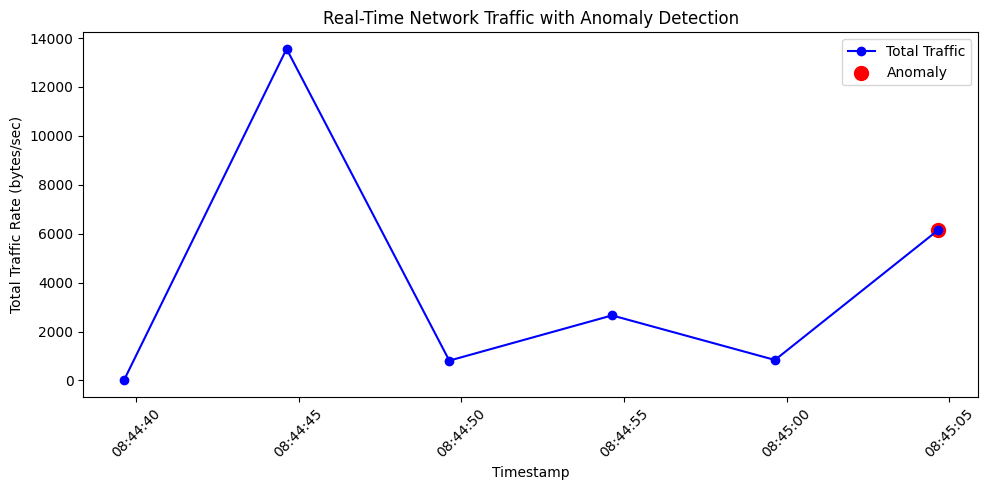

In [ ]:
print(live_df[["timestamp", "total_rate", "rolling_mean", "rolling_std"]])
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(live_df["timestamp"], live_df["total_rate"], label="Total Traffic", color="blue", marker="o")
plt.scatter(anomalies["timestamp"], anomalies["total_rate"], color="red", label="Anomaly", s=100)
plt.xlabel("Timestamp")
plt.ylabel("Total Traffic Rate (bytes/sec)")
plt.title("Real-Time Network Traffic with Anomaly Detection")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Robust Step 1: data prep for LSTM (fixed for non-numeric columns)
!pip install -q pandas numpy scikit-learn tensorflow joblib

import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

csv_path = "WiFiData.csv"
TIMESTEPS = 10

if os.path.exists(csv_path):
    print("Loading WiFiData.csv")
    raw = pd.read_csv(csv_path, low_memory=False)
    # Try to find datetime-like columns
    if 'Datetime' not in raw.columns:
        if {'Date', 'Time'}.issubset(raw.columns):
            raw['Datetime'] = raw['Date'].astype(str).str.strip() + ' ' + raw['Time'].astype(str).str.strip()
        elif 'Date' in raw.columns:
            raw['Datetime'] = raw['Date'].astype(str).str.strip()
        else:
            # fallback: create index as a simple range of timestamps
            raw['Datetime'] = pd.date_range(start='2025-01-01', periods=len(raw), freq='S')
    # parse Datetime, coerce errors -> NaT
    raw['Datetime'] = pd.to_datetime(raw['Datetime'], errors='coerce')
    # drop rows with invalid datetime
    raw = raw.dropna(subset=['Datetime']).reset_index(drop=True)
else:
    print("WiFiData.csv not found → generating synthetic dataset (for training)")
    n = 2000
    time_idx = pd.date_range(start="2025-01-01", periods=n, freq="S")
    traffic = np.sin(np.linspace(0, 40, n)) * 50 + 600 + np.random.randn(n)*30
    sent = traffic * np.random.uniform(0.45, 0.6, size=n)
    recv = traffic - sent
    raw = pd.DataFrame({
        "Datetime": time_idx,
        "SpeedDownload": traffic,
        "sent_rate": sent,
        "recv_rate": recv
    })

# Make numeric conversions for suspect columns
for col in ['SpeedDownload','sent_rate','recv_rate','StrengthStrongest','NumberofAvailableNetworks','NumberOfDevices']:
    if col in raw.columns:
        raw[col] = pd.to_numeric(raw[col], errors='coerce')

# If neither sent_rate nor recv_rate present, try derive from SpeedDownload
if 'sent_rate' not in raw.columns or 'recv_rate' not in raw.columns:
    if 'SpeedDownload' in raw.columns:
        raw['total_rate'] = raw['SpeedDownload'].astype(float)
        raw['sent_rate'] = raw['total_rate'] * 0.45
        raw['recv_rate'] = raw['total_rate'] * 0.55
    else:
        # fallback random
        raw['sent_rate'] = np.random.uniform(200, 2000, size=len(raw))
        raw['recv_rate'] = np.random.uniform(200, 2000, size=len(raw))

# Ensure total_rate exists
raw['total_rate'] = raw['sent_rate'].astype(float) + raw['recv_rate'].astype(float)

# Index by Datetime and resample numeric columns only
raw = raw.set_index(pd.to_datetime(raw['Datetime']))
numeric = raw.select_dtypes(include=[np.number])
# Resample to 1-second frequency (or adjust as needed)
numeric = numeric.resample('1s').mean().interpolate(method='linear')

# If numeric is very short, ensure length >= TIMESTEPS+1
if len(numeric) < TIMESTEPS + 5:
    needed = TIMESTEPS + 200
    print(f"Warning: numeric series is short ({len(numeric)}). Generating extra synthetic points to reach {needed}.")
    extra_n = needed - len(numeric)
    last_ts = numeric.index[-1]
    extra_idx = pd.date_range(start=last_ts + pd.Timedelta(seconds=1), periods=extra_n, freq='1s')
    # generate small random jitter based on last value
    last_val = numeric['total_rate'].iloc[-1]
    extra = pd.DataFrame({
        'total_rate': last_val + np.random.randn(extra_n) * (0.05 * last_val),
        'sent_rate': (last_val/2) + np.random.randn(extra_n) * (0.02 * last_val),
        'recv_rate': (last_val/2) + np.random.randn(extra_n) * (0.02 * last_val),
    }, index=extra_idx)
    numeric = pd.concat([numeric, extra])

# Use the resampled numeric DataFrame for sequence creation
df = numeric.reset_index().rename(columns={'index':'Datetime'})  # Datetime is index name

# Prepare array for LSTM (use 'total_rate' as feature)
values = df['total_rate'].values.reshape(-1,1)

# Scale values
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# Create sliding windows
X, y = [], []
for i in range(TIMESTEPS, len(scaled)):
    X.append(scaled[i-TIMESTEPS:i, 0])
    y.append(scaled[i, 0])

X = np.array(X).reshape(-1, TIMESTEPS, 1)
y = np.array(y)

print("Data prepared.")
print("Numeric df head:")
display(df.head(6))
print("Scaled X shape:", X.shape)
print("y shape:", y.shape)
print("Sample X[0] (scaled):", X[0].flatten()[:10])
print("Sample y[0] (scaled):", y[0])

# Save outputs for training
np.save("X_train_ready.npy", X)
np.save("y_train_ready.npy", y)
joblib.dump(scaler, "scaler.save")
print("\nSaved: X_train_ready.npy, y_train_ready.npy, scaler.save")


Loading WiFiData.csv
Data prepared.
Numeric df head:


,Datetime,SpeedDownload,SpeedUpload,StrengthStrongest,NumberofAvailableNetworks,NumberOfDevices,total_rate,sent_rate,recv_rate
0,2019-10-01 11:37:00,42.700000,50.634000,-54.750000,23.000000,NaN,42.700000,19.215000,23.485000
1,2019-10-01 11:37:01,42.700354,50.634782,-54.749922,22.999957,NaN,42.700354,19.215159,23.485195
2,2019-10-01 11:37:02,42.700707,50.635564,-54.749844,22.999914,NaN,42.700707,19.215318,23.485389
3,2019-10-01 11:37:03,42.701061,50.636346,-54.749766,22.999872,NaN,42.701061,19.215477,23.485584
4,2019-10-01 11:37:04,42.701415,50.637127,-54.749688,22.999829,NaN,42.701415,19.215637,23.485778
5,2019-10-01 11:37:05,42.701768,50.637909,-54.749610,22.999786,NaN,42.701768,19.215796,23.485973


Scaled X shape: (690051, 10, 1)
y shape: (690051,)
Sample X[0] (scaled): [0.2848493  0.28485168 0.28485406 0.28485644 0.28485882 0.2848612
 0.28486358 0.28486596 0.28486834 0.28487071]
Sample y[0] (scaled): 0.2848730939850809

Saved: X_train_ready.npy, y_train_ready.npy, scaler.save


In [ ]:
# Step 2 — Train and Save the LSTM Model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import joblib

# Load prepared data
X = np.load("X_train_ready.npy")
y = np.load("y_train_ready.npy")

print("Loaded X:", X.shape)
print("Loaded y:", y.shape)

# Define LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# Add callbacks
checkpoint = ModelCheckpoint("lstm_model.keras", save_best_only=True, monitor="val_loss", mode="min")
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    X, y,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

print("\n✅ Model training complete and saved as 'lstm_model.keras'")


Loaded X: (690051, 10, 1)
Loaded y: (690051,)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8626/8626 ━━━━━━━━━━━━━━━━━━━━ 160s 18ms/step - loss: 5.9783e-04 - mae: 0.0072 - val_loss: 1.5225e-05 - val_mae: 0.0037
Epoch 2/10
8626/8626 ━━━━━━━━━━━━━━━━━━━━ 144s 17ms/step - loss: 1.5826e-05 - mae: 0.0028 - val_loss: 1.9932e-06 - val_mae: 0.0011
Epoch 3/10
8626/8626 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - loss: 1.3001e-05 - mae: 0.0026 - val_loss: 8.6989e-07 - val_mae: 2.9670e-04
Epoch 4/10
8626/8626 ━━━━━━━━━━━━━━━━━━━━ 144s 17ms/step - loss: 1.0707e-05 - mae: 0.0023 - val_loss: 1.2087e-06 - val_mae: 8.1993e-04
Epoch 5/10
8626/8626 ━━━━━━━━━━━━━━━━━━━━ 147s 17ms/step - loss: 9.6279e-06 - mae: 0.0022 - val_loss: 2.1443e-06 - val_mae: 0.0013
Epoch 6/10
8626/8626 ━━━━━━━━━━━━━━━━━━━━ 155s 18ms/step - loss: 8.3634e-06 - mae: 0.0021 - val_loss: 8.8851e-07 - val_mae: 4.9220e-04

✅ Model training complete and saved as 'lstm_model.keras'


In [ ]:
import gradio as gr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, psutil
from io import BytesIO
from PIL import Image
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import shap, tempfile, warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# -------------------------------
# Load trained LSTM model
model = load_model("lstm_model.keras")

# Global settings
window_size = 10
sequence_buffer = []
history_df = pd.DataFrame(columns=["timestamp", "sent_rate", "recv_rate", "total_rate"])
stop_flag = False

# -------------------------------
def collect_live_network_data(interval=2):
    start = psutil.net_io_counters()
    time.sleep(interval)
    end = psutil.net_io_counters()
    sent_rate = (end.bytes_sent - start.bytes_sent) / interval
    recv_rate = (end.bytes_recv - start.bytes_recv) / interval
    total_rate = sent_rate + recv_rate
    df = pd.DataFrame({
        "timestamp": [pd.Timestamp.now()],
        "sent_rate": [sent_rate],
        "recv_rate": [recv_rate],
        "total_rate": [total_rate],
    })
    return df

def simulate_realtime_data(interval=2):
    time.sleep(interval)
    timestamp = pd.Timestamp.now()
    base_rate = np.random.uniform(2e6, 4e6)
    sent_rate = base_rate * np.random.uniform(0.8, 1.2)
    recv_rate = base_rate * np.random.uniform(0.8, 1.2)
    if np.random.random() < 0.05:
        sent_rate *= np.random.uniform(2.0, 3.5)
        recv_rate *= np.random.uniform(2.0, 3.5)
    elif np.random.random() < 0.03:
        sent_rate *= np.random.uniform(0.3, 0.6)
        recv_rate *= np.random.uniform(0.3, 0.6)
    total_rate = sent_rate + recv_rate
    return pd.DataFrame({
        "timestamp": [timestamp],
        "sent_rate": [sent_rate],
        "recv_rate": [recv_rate],
        "total_rate": [total_rate],
    })

# -------------------------------
def model_predict_from_seq(seq, model):
    seq = list(seq)
    if len(seq) == 0:
        return 0.0
    if len(seq) < window_size:
        seq = [seq[0]] * (window_size - len(seq)) + seq
    arr = np.array(seq).reshape(-1, 1).astype(float)
    local_scaler = MinMaxScaler()
    arr_scaled = local_scaler.fit_transform(arr).reshape(1, window_size, 1)
    pred_scaled = model.predict(arr_scaled, verbose=0)
    pred = local_scaler.inverse_transform(pred_scaled.reshape(-1, 1))[0][0]
    return float(pred)

# -------------------------------
def predict_traffic(df):
    global sequence_buffer
    val = float(df["total_rate"].iloc[-1])
    sequence_buffer.append(val)
    if len(sequence_buffer) > window_size:
        sequence_buffer = sequence_buffer[-window_size:]
    if len(sequence_buffer) < 1:
        return val
    return model_predict_from_seq(sequence_buffer, model)

# -------------------------------
def forecast_next_steps(seq, steps=10):
    seq = list(seq)
    if len(seq) < window_size:
        seq = [seq[0]] * (window_size - len(seq)) + seq
    arr = np.array(seq).reshape(-1, 1).astype(float)
    local_scaler = MinMaxScaler()
    arr_scaled = local_scaler.fit_transform(arr).reshape(1, window_size, 1)
    current_seq = arr_scaled.copy()
    preds_scaled = []
    for _ in range(steps):
        next_scaled = model.predict(current_seq, verbose=0)[0, 0]
        preds_scaled.append(next_scaled)
        next_scaled_arr = np.array([[[next_scaled]]])
        current_seq = np.append(current_seq[:, 1:, :], next_scaled_arr, axis=1)
    preds = local_scaler.inverse_transform(np.array(preds_scaled).reshape(-1, 1)).flatten()
    return preds

# -------------------------------
def start_monitoring(interval, mode):
    global history_df, stop_flag, sequence_buffer
    stop_flag = False
    if not history_df.empty:
        sequence_buffer = history_df["total_rate"].dropna().astype(float).tolist()[-window_size:]

    while not stop_flag:
        new_df = collect_live_network_data(interval) if mode == "Live" else simulate_realtime_data(interval)
        history_df = pd.concat([history_df, new_df]).tail(50).reset_index(drop=True)
        history_df["timestamp"] = pd.to_datetime(history_df["timestamp"])
        history_df["rolling_mean"] = history_df["total_rate"].rolling(window=5, min_periods=1).mean()
        history_df["rolling_std"] = history_df["total_rate"].rolling(window=5, min_periods=1).std().fillna(0)
        history_df["threshold"] = history_df["rolling_mean"] + 1.5 * history_df["rolling_std"]
        history_df["anomaly"] = history_df["total_rate"] > history_df["threshold"]
        predicted_load = predict_traffic(new_df)

        # New: Calculate Anomaly Count
        anomaly_count = int(history_df["anomaly"].sum())

        preds_hist = []
        for i in range(len(history_df)):
            seq_i = history_df["total_rate"].iloc[max(0, i - window_size + 1): i + 1].astype(float).tolist()
            preds_hist.append(model_predict_from_seq(seq_i, model))

        seq_for_forecast = sequence_buffer[-window_size:] if len(sequence_buffer) >= 1 else history_df["total_rate"].astype(float).tolist()[-window_size:]
        if len(seq_for_forecast) < 1:
            seq_for_forecast = [0.0] * window_size
        future_forecast, future_timestamps = None, None
        if len(seq_for_forecast) >= 1:
            future_forecast = forecast_next_steps(seq_for_forecast, steps=10)
            last_ts = history_df["timestamp"].iloc[-1]
            future_timestamps = pd.date_range(start=last_ts + pd.Timedelta(seconds=interval),
                                              periods=len(future_forecast), freq=f"{int(interval)}s")

        plt.figure(figsize=(8, 4))
        plt.plot(history_df["timestamp"], history_df["total_rate"], color='blue', label="Actual Traffic", marker='o', markersize=4)
        plt.plot(history_df["timestamp"], preds_hist, color='green', linestyle='--', label="Predicted (per-sample)")
        if future_forecast is not None:
            plt.plot(future_timestamps, future_forecast, color='orange', linestyle=':', marker='x', label="Future Forecast")
        anomalies = history_df[history_df["anomaly"] == True]
        if not anomalies.empty:
            plt.scatter(anomalies["timestamp"], anomalies["total_rate"], color='red', s=80, label="🚨 Anomaly", zorder=5)
        plt.xlabel("Timestamp")
        plt.ylabel("Bytes/sec")
        plt.title(f"{'Simulated' if mode == 'Simulation' else 'Live'} Traffic Monitoring + Forecast")
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        buf = BytesIO()
        plt.savefig(buf, format="png")
        plt.close()
        buf.seek(0)
        img = Image.open(buf)

        # Updated return statement to include anomaly_count
        yield (
            "🚨 Anomaly Detected" if history_df["anomaly"].iloc[-1] else "✅ Normal Traffic",
            round(predicted_load, 2),
            img,
            anomaly_count # new return value
        )

def stop_monitoring():
    global stop_flag
    stop_flag = True
    # Updated return statement to include anomaly_count (0)
    return "🛑 Monitoring Stopped", 0, None, 0

# -------------------------------
# ✅ SHAP Explainability inside Gradio
# NOTE: The provided code for X_test is missing, so this section might raise an error if run without defining X_test first.
def analyze_feature_importance():
    try:
        # NOTE: X_test is not defined in the provided context and would cause a NameError
        # Assuming X_test is a global or correctly defined variable elsewhere
        X_sample = np.array(X_test)
        if X_sample.ndim == 2:
            X_sample = np.expand_dims(X_sample, -1)
        print(f"✅ Final X_sample shape for SHAP: {X_sample.shape}")

        # ✅ Step 2: Try DeepExplainer first (for LSTM)
        try:
            explainer = shap.DeepExplainer(model, X_sample[:5])
            shap_values = explainer.shap_values(X_sample[:8])
            print("✅ DeepExplainer used successfully.")
        except Exception as e:
            print(f"⚠ DeepExplainer failed ({e}), switching to KernelExplainer...")

            # Fallback to KernelExplainer
            background = X_sample[:5].reshape(5, -1)
            test_data = X_sample[:8].reshape(8, -1)

            def predict_fn(data):
                reshaped = data.reshape(data.shape[0], X_sample.shape[1], 1)
                return model.predict(reshaped, verbose=0)

            explainer = shap.KernelExplainer(predict_fn, background)
            shap_values = explainer.shap_values(test_data, nsamples=40)
            X_sample = test_data  # adjust for 2D shape

        # ✅ Step 3: Define feature names dynamically
        n_features = X_sample.shape[1]
        feature_names = [
            "SpeedDownload", "SpeedUpload", "StrengthStrongest",
            "NumberofAvailableNetworks", "NumberOfDevices"
        ][:n_features]

        # ✅ Step 4: Save SHAP plot as temp image
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp:
            plt.figure()
            shap.summary_plot(shap_values, X_sample.reshape(X_sample.shape[0], -1),
                              feature_names=feature_names, show=False)
            plt.tight_layout()
            plt.savefig(tmp.name, bbox_inches='tight')
            plt.close()
            shap_plot_path = tmp.name

        print("✅ SHAP analysis successful — Feature importance image generated.")
        return "✅ SHAP Analysis Complete", shap_plot_path

    except Exception as e:
        return f"❌ SHAP error: {str(e)}", None


# -------------------------------
# Gradio Interface
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("## 📡Wi-Fi Network Traffic Monitor")
    with gr.Row():
        interval = gr.Slider(1, 10, value=3, step=1, label="⏱ Sampling Interval (seconds)")
        mode = gr.Radio(["Live", "Simulation"], value="Live", label="Mode")
    with gr.Row():
        start_btn = gr.Button("🚀 Start Monitoring", variant="primary")
        stop_btn = gr.Button("🛑 Stop Monitoring")

    # New Row for Anomaly Count
    with gr.Row():
        anomaly = gr.Textbox(label="Anomaly Status")
        prediction = gr.Number(label="Predicted Traffic Load (bytes/sec)")
        # New: Anomaly Count Component
        anomaly_count_box = gr.Number(label="🚨 Total Anomalies Detected", precision=0)

    chart = gr.Image(label="📊 Live + Future Forecast Visualization")

    gr.Markdown("### Feature Importance (Explainability)")
    shap_btn = gr.Button("Run SHAP Analysis")
    shap_status = gr.Textbox(label="SHAP Status")
    shap_plot = gr.Image(label="Feature Impact Visualization")

    # Update click bindings to include the new anomaly_count_box output
    start_btn.click(start_monitoring, inputs=[interval, mode], outputs=[anomaly, prediction, chart, anomaly_count_box])
    stop_btn.click(stop_monitoring, outputs=[anomaly, prediction, chart, anomaly_count_box])
    shap_btn.click(analyze_feature_importance, outputs=[shap_status, shap_plot])
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2b5b9795189928baa.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
